In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import os

In [9]:
DF_PATH : str = r'../data/main_ready.csv'
TARGET : str = 'type'
TARGET_2 : str = 'quality'
PLOT_SAVE_PATH : str = r'../plots/'
# Load the dataset
data = pd.read_csv(DF_PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   quality               6497 non-null   int64  
 2   citric acid           6497 non-null   float64
 3   volatile acidity      6497 non-null   float64
 4   pH                    6497 non-null   float64
 5   fixed acidity         6497 non-null   float64
 6   sulphates             6497 non-null   float64
 7   chlorides             6497 non-null   float64
 8   residual sugar        6497 non-null   float64
 9   free sulfur dioxide   6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  total sulfur dioxide  6497 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 609.2 KB


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# ---- 1. Data preparation function ----
def prepare_data(df, target_col=TARGET, test_size=0.2, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Encode target if it's categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test
                 


In [17]:
# ---- 2. Model training functions ----

def train_knn(X_train, X_test, y_train, y_test):
    param_grid = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}
    knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return knn.best_estimator_, accuracy_score(y_test, y_pred)

def train_random_forest(X_train, X_test, y_train, y_test):
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 20]}
    rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return rf.best_estimator_, accuracy_score(y_test, y_pred)

def train_decision_tree(X_train, X_test, y_train, y_test):
    param_grid = {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10]}
    dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    return dt.best_estimator_, accuracy_score(y_test, y_pred)

def train_naive_bayes(X_train, X_test, y_train, y_test):
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    return nb, accuracy_score(y_test, y_pred)



# ---- 3. Global function to run all models ----
def run_all_models(df, target_col=TARGET):
    X_train, X_test, y_train, y_test = prepare_data(df, target_col)
    
    models = {
        "KNN": train_knn,
        "Random Forest": train_random_forest,
        "Decision Tree": train_decision_tree,
        "Naive Bayes": train_naive_bayes,
    }
    
    results = {}
    
    for name, func in models.items():
        model, acc = func(X_train, X_test, y_train, y_test)
        results[name] = acc
        print(f"{name} accuracy: {acc:.4f}")
    
    return results

# ---- Usage example ----
results = run_all_models(data)

KNN accuracy: 0.9900
Random Forest accuracy: 0.9915
Decision Tree accuracy: 0.9792
Naive Bayes accuracy: 0.9608


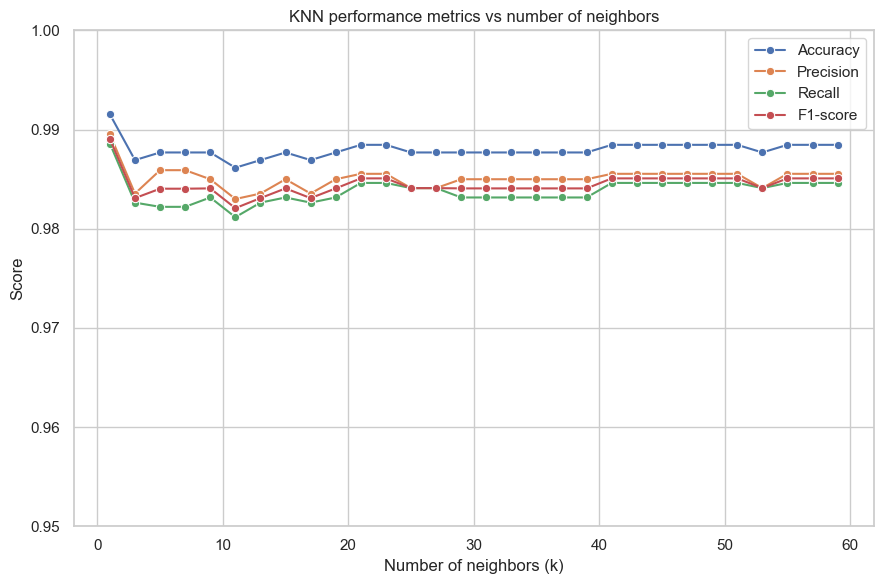

In [16]:
def knn_neighbors_analysis(
    X_train,
    X_test,
    y_train,
    y_test,
    save: bool = True
):
    """
    Train KNN models with different odd numbers of neighbors
    and plot multiple classification metrics as a function of n_neighbors.
    """

    neighbors = list(range(1, 61, 2))

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for k in neighbors:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(
            precision_score(y_test, y_pred, average="macro", zero_division=0)
        )
        recall_list.append(
            recall_score(y_test, y_pred, average="macro", zero_division=0)
        )
        f1_list.append(
            f1_score(y_test, y_pred, average="macro", zero_division=0)
        )

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(9, 6))

    sns.lineplot(x=neighbors, y=accuracy_list, label="Accuracy", marker="o")
    sns.lineplot(x=neighbors, y=precision_list, label="Precision", marker="o")
    sns.lineplot(x=neighbors, y=recall_list, label="Recall", marker="o")
    sns.lineplot(x=neighbors, y=f1_list, label="F1-score", marker="o")

    plt.xlabel("Number of neighbors (k)")
    plt.ylabel("Score")
    plt.title("KNN performance metrics vs number of neighbors")
    plt.ylim(0.95, 1.0)
    plt.legend()
    plt.tight_layout()

    if save:
        os.makedirs(PLOT_SAVE_PATH, exist_ok=True)
        plt.savefig(
            os.path.join(PLOT_SAVE_PATH, "knn_neighbors_metrics.png")
        )

    plt.show()

knn_neighbors_analysis(*prepare_data(data, TARGET))

Le meilleur compromis de performance est atteint pour k = 1.
Toutefois, cette valeur correspond à un modèle à très forte variance, ce qui suggère un possible sur-apprentissage ou une forte redondance des données.
Des analyses complémentaires sont nécessaires pour valider la capacité de généralisation du modèle.

## Regression sur la qualité du vin 

Utiliser "TARGET_2"

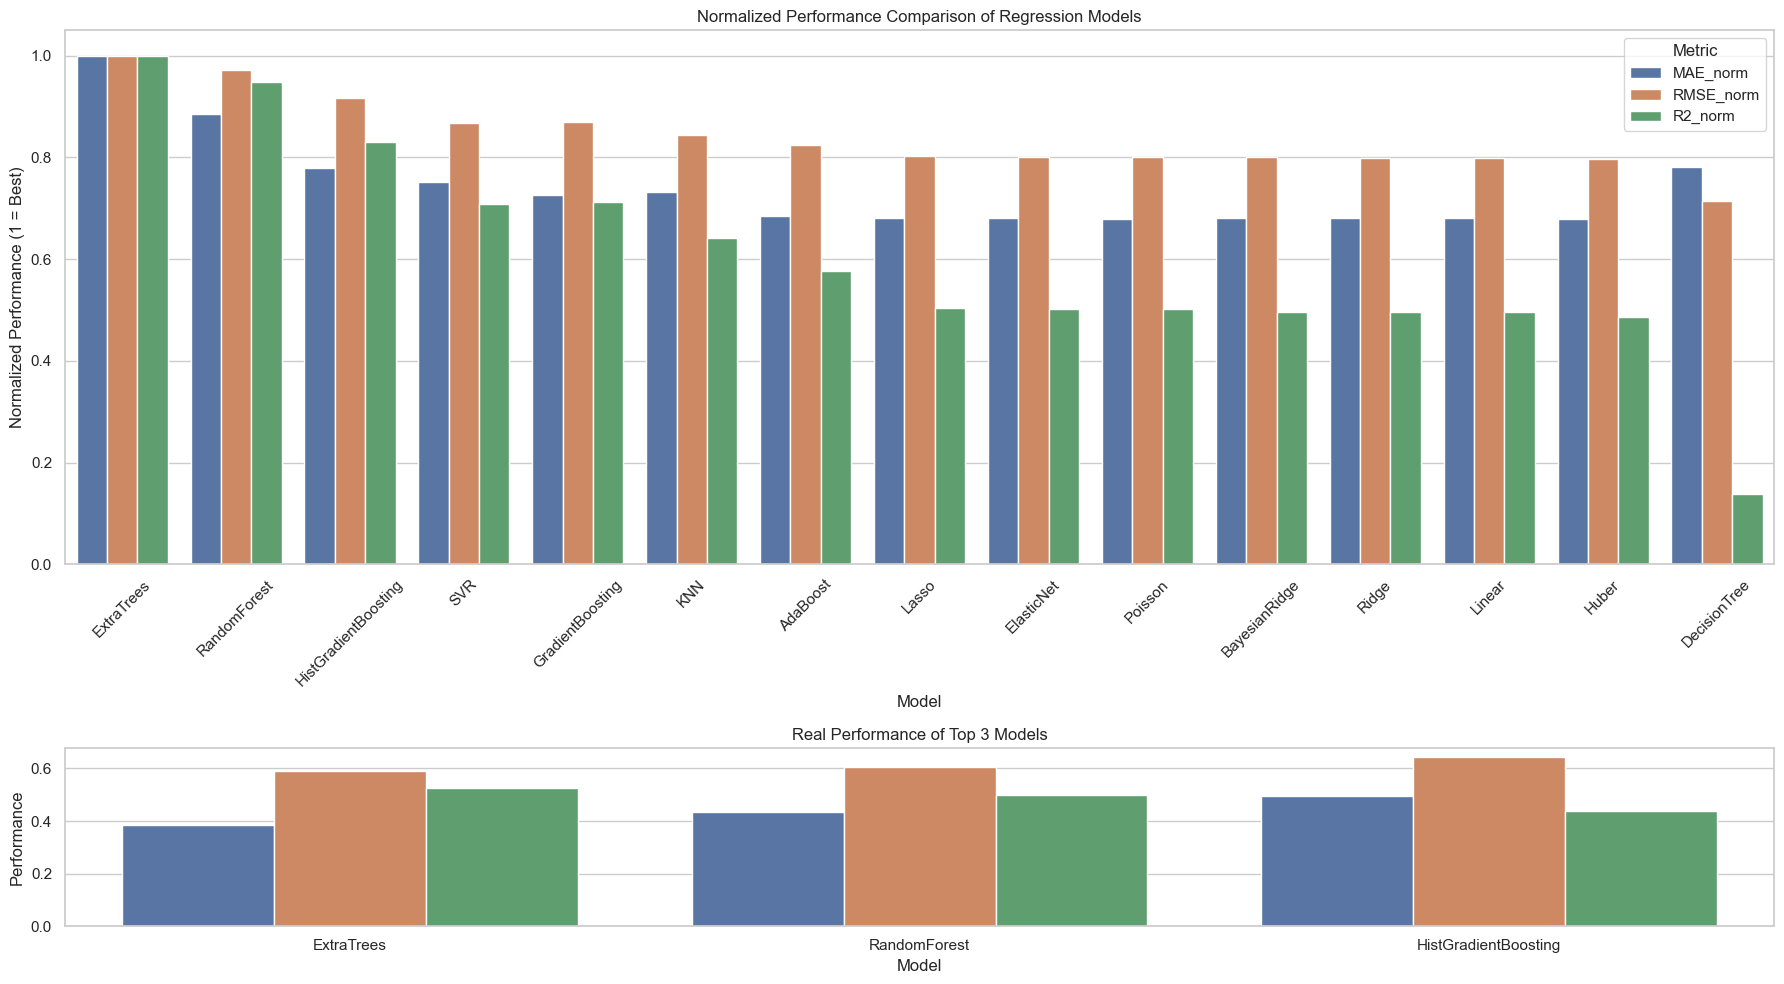

,Model,MAE,RMSE,R2,MAE_norm,RMSE_norm,R2_norm,GlobalScore
9,ExtraTrees,0.386035,0.590719,0.527520,1.000000,1.000000,1.000000,1.000000
8,RandomForest,0.435719,0.607341,0.500555,0.885971,0.972631,0.948885,0.935829
11,HistGradientBoosting,0.494936,0.644461,0.437638,0.779969,0.916609,0.829615,0.842064
5,SVR,0.513486,0.680332,0.373294,0.751791,0.868281,0.707641,0.775904
10,GradientBoosting,0.532024,0.679058,0.375639,0.725596,0.869909,0.712085,0.769197
6,KNN,0.527692,0.699010,0.338410,0.731552,0.845079,0.641511,0.739381
12,AdaBoost,0.564070,0.716760,0.304384,0.684373,0.824151,0.577009,0.695178
2,Lasso,0.567654,0.736330,0.265879,0.680052,0.802247,0.504017,0.662106
3,ElasticNet,0.566936,0.736718,0.265107,0.680913,0.801825,0.502553,0.661764
14,Poisson,0.568114,0.736974,0.264596,0.679503,0.801547,0.501585,0.660878


In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, HuberRegressor, PoissonRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, HistGradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


PLOT_SAVE_PATH = "plots"


def evaluate_many_regression_models(
    X_train, X_test, y_train, y_test, save=True
):
    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.01),
        "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
        "BayesianRidge": BayesianRidge(),

        "SVR": SVR(kernel="rbf"),
        "KNN": KNeighborsRegressor(n_neighbors=5),

        "DecisionTree": DecisionTreeRegressor(random_state=42),

        "RandomForest": RandomForestRegressor(
            n_estimators=200, random_state=42
        ),
        "ExtraTrees": ExtraTreesRegressor(
            n_estimators=200, random_state=42
        ),

        "GradientBoosting": GradientBoostingRegressor(random_state=42),
        "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
        "AdaBoost": AdaBoostRegressor(random_state=42),

        "Huber": HuberRegressor(),
        "Poisson": PoissonRegressor()
    }

    raw_results = []

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            raw_results.append({
                "Model": name,
                "MAE": mean_absolute_error(y_test, y_pred),
                "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
                "R2": r2_score(y_test, y_pred)
            })
        except Exception:
            continue

    results_df = pd.DataFrame(raw_results)

    # Normalization relative to best observed performance
    results_df["MAE_norm"] = results_df["MAE"].min() / results_df["MAE"]
    results_df["RMSE_norm"] = results_df["RMSE"].min() / results_df["RMSE"]
    results_df["R2_norm"] = results_df["R2"] / results_df["R2"].max()

    # Global score for ranking
    results_df["GlobalScore"] = (
        results_df["MAE_norm"]
        + results_df["RMSE_norm"]
        + results_df["R2_norm"]
    ) / 3.0

    # Sort models from best to worst
    results_df = results_df.sort_values(
        "GlobalScore", ascending=False
    )

    # Prepare full plot data (normalized)
    plot_df_norm = results_df.melt(
        id_vars="Model",
        value_vars=["MAE_norm", "RMSE_norm", "R2_norm"],
        var_name="Metric",
        value_name="Score"
    )

    # Top 3 models (for real, non-normalized metrics)
    top3_models = results_df.head(3)["Model"].tolist()
    top3_df_real = results_df[results_df["Model"].isin(top3_models)].melt(
        id_vars="Model",
        value_vars=["MAE", "RMSE", "R2"],
        var_name="Metric",
        value_name="Score"
    )

    # Create subplots
    fig, axes = plt.subplots(
        2, 1, figsize=(18, 10),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Main comparison plot (normalized)
    sns.barplot(
        data=plot_df_norm,
        x="Model",
        y="Score",
        hue="Metric",
        ax=axes[0]
    )
    axes[0].set_title(
        "Normalized Performance Comparison of Regression Models"
    )
    axes[0].set_ylabel("Normalized Performance (1 = Best)")
    axes[0].set_ylim(0, 1.05)
    axes[0].tick_params(axis="x", rotation=45)

    # Bottom plot: top 3 models (real metrics)
    sns.barplot(
        data=top3_df_real,
        x="Model",
        y="Score",
        hue="Metric",
        ax=axes[1]
    )
    axes[1].set_title("Real Performance of Top 3 Models")
    axes[1].set_ylabel("Performance")
    axes[1].tick_params(axis="x", rotation=0)
    axes[1].get_legend().remove()  # avoid duplicate legend

    plt.tight_layout()

    if save:
        os.makedirs(PLOT_SAVE_PATH, exist_ok=True)
        plt.savefig(
            os.path.join(
                PLOT_SAVE_PATH,
                "regression_models_with_top3_real.png"
            ),
            dpi=300
        )

    plt.show()

    return results_df

evaluate_many_regression_models(*prepare_data(data, TARGET_2))

c:\Users\colin\anaconda3\envs\LO17_RAG\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\colin\anaconda3\envs\LO17_RAG\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\colin\anaconda3\envs\LO17_RAG\lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\colin\anaconda3\envs\LO17_RAG\lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constra

ExtraTrees - Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None}
ExtraTrees - Test Metrics: {'MAE': 0.3806615384615385, 'RMSE': 0.5834956330994722, 'R2': 0.5390039210219334}
RandomForest - Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
RandomForest - Test Metrics: {'MAE': 0.43290214438957564, 'RMSE': 0.5955889300493928, 'R2': 0.5196970594902726}


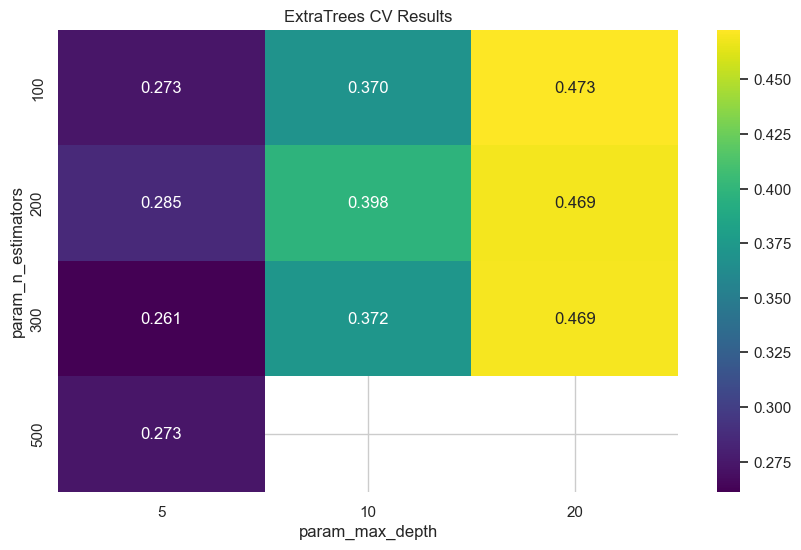

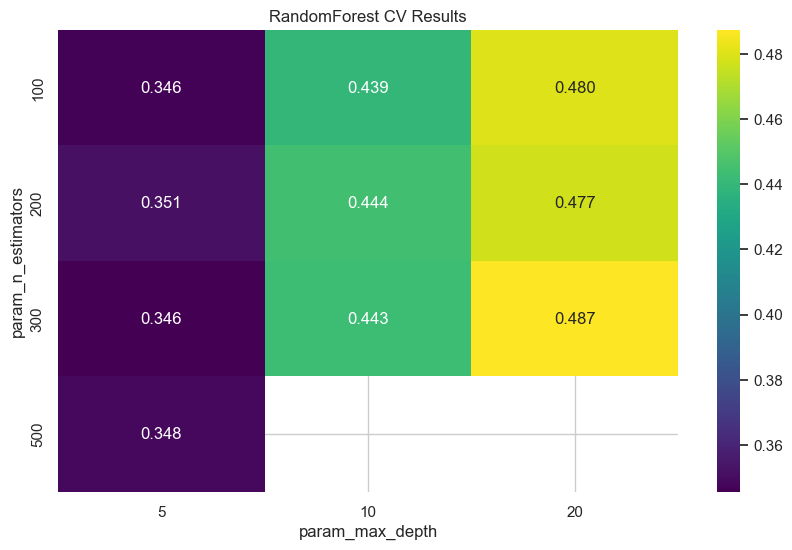

<Figure size 640x480 with 0 Axes>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Définition des grilles d'hyperparamètres
param_grid_extra = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5, 0.7]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5, 0.7]
}

# Fonction générique de tuning
def tune_model(model, param_grid, X_train, y_train, X_test, y_test, n_iter=30):
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    
    return best_model, search.best_params_, metrics, search.cv_results_

def plot_cv_results(cv_results, param1='param_n_estimators', param2='param_max_depth', metric='mean_test_score', title=''):
    df = pd.DataFrame(cv_results)
    pivot_table = df.pivot_table(
        index=param1,
        columns=param2,
        values=metric
    )
    
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
    plt.title(title)
    plt.ylabel(param1)
    plt.xlabel(param2)
    plt.show()




# Tuning ExtraTrees
def tune_ensemble_models(X_train, X_test, y_train, y_test, save = True):
    # Tuning ExtraTrees
    best_extra, best_params_extra, metrics_extra, cv_results_extra = tune_model(
        ExtraTreesRegressor(random_state=42),
        param_grid_extra,
        X_train, y_train, X_test, y_test
    )

    # Tuning RandomForest
    best_rf, best_params_rf, metrics_rf, cv_results_rf = tune_model(
        RandomForestRegressor(random_state=42),
        param_grid_rf,
        X_train, y_train, X_test, y_test
    )

    # Affichage des résultats
    print("ExtraTrees - Best Params:", best_params_extra)
    print("ExtraTrees - Test Metrics:", metrics_extra)
    print("RandomForest - Best Params:", best_params_rf)
    print("RandomForest - Test Metrics:", metrics_rf)


    # Plot CV results
    plot_cv_results(
        cv_results_extra,
        title='ExtraTrees CV Results'
    )
    plot_cv_results(
        cv_results_rf,
        title='RandomForest CV Results'
    )
    if save:
        os.makedirs(PLOT_SAVE_PATH, exist_ok=True)
        plt.savefig(
            os.path.join(
                PLOT_SAVE_PATH,
                "ensemble_models_cv_results.png"
            ),
            dpi=300
        )
    plt.show()

tune_ensemble_models(*prepare_data(data, TARGET_2))

